In [1]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from copy import deepcopy

/ext3/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')

y


In [3]:
# Sample Data
sample_train_data = pd.read_csv( '../data/train_sample_fabric.csv')
sample_val_data =  pd.read_csv( '../data/val_sample_fabric.csv')
sample_test_data =  pd.read_csv( '../data/test_sample_fabric.csv')

In [4]:
# Full Data
full_train_data = pd.read_csv( '../data/classification_train.csv')
full_val_data =  pd.read_csv( '../data/classification_val.csv')
full_test_data =  pd.read_csv( '../data/classification_test.csv')

In [5]:
class FashionDataset(Dataset):
    def __init__(self, data_frame, img_dir, label, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = data_frame
        self.img_dir = img_dir
        self.clothing_type = data_frame['clothing_type']
        self.label = data_frame[label]

        self.transform = transform            

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.label[idx]
        clothing_type = self.clothing_type[idx] 
        
        #Resize image and label to 572x572
        image = image.resize((572, 572))

        #Normalize the image
        image = np.asarray(image)
        min_image = np.min(image)
        max_image = np.max(image)
        image = (image - min_image)/(max_image - min_image + 1e-4)

        #Convert to tensors
        image = torch.tensor(np.array(image)).float().permute(2, 0, 1)
        label = torch.tensor(label).long()
        clothing_type = torch.tensor(clothing_type).long()
        sample = {'x': image, 'y': label, 'c': clothing_type}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(weights=None) 
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, 6)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [7]:
def train_model(model, dataloader, optimizer,  loss_fn, num_epochs = 10, verbose = False):
    f1_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_loss = np.inf
    best_f1 = 0
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            all_preds = []
            all_labels = []
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()            
                image = data['x'].to(device)
                label = data['y'].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(label.cpu().numpy())
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f} F1 {:.4f}'.format(p, epoch_loss, epoch_acc, epoch_f1))

            f1_dict[p].append(epoch_f1)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_f1 > best_f1:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_f1 = epoch_f1
                    best_model_wts = deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best model val acc: {:4f} Best model val F1: {:4f}'.format(best_acc, best_f1))
    
    model.load_state_dict(best_model_wts)
    
    return model, f1_dict, loss_dict


### Baseline Fabric Classification Model

In [8]:
bs = 16
resnet_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'fabric')}

resnet_dataloader = {x: DataLoader(resnet_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [9]:
resnet_model_fabric = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model_fabric.parameters(), lr=0.001)

resnet_model_fabric, resnet_f1_dict, resnet_loss_dict = train_model(resnet_model_fabric, 
                                                                     resnet_dataloader, 
                                                                     optimizer, 
                                                                     loss_fn=criterion, 
                                                                     num_epochs=10, 
                                                                     verbose=True)

Epoch: 0/9
----------
Phase:train, epoch loss: 0.9795 Acc: 0.6593 F1 0.2221
Phase:validate, epoch loss: 0.9554 Acc: 0.6516 F1 0.2246
Epoch: 1/9
----------
Phase:train, epoch loss: 0.8419 Acc: 0.7082 F1 0.2742
Phase:validate, epoch loss: 6.6875 Acc: 0.0498 F1 0.0369
Epoch: 2/9
----------
Phase:train, epoch loss: 0.7831 Acc: 0.7269 F1 0.3379
Phase:validate, epoch loss: 2.7335 Acc: 0.1907 F1 0.1200
Epoch: 3/9
----------
Phase:train, epoch loss: 0.7583 Acc: 0.7360 F1 0.3751
Phase:validate, epoch loss: 0.9087 Acc: 0.6871 F1 0.3473
Epoch: 4/9
----------
Phase:train, epoch loss: 0.7358 Acc: 0.7413 F1 0.3969
Phase:validate, epoch loss: 4.2470 Acc: 0.0644 F1 0.0502
Epoch: 5/9
----------
Phase:train, epoch loss: 0.7148 Acc: 0.7493 F1 0.4266
Phase:validate, epoch loss: 1.5091 Acc: 0.5433 F1 0.3053
Epoch: 6/9
----------
Phase:train, epoch loss: 0.6939 Acc: 0.7564 F1 0.4516
Phase:validate, epoch loss: 0.8251 Acc: 0.7235 F1 0.3923
Epoch: 7/9
----------
Phase:train, epoch loss: 0.6723 Acc: 0.7592 F1 

In [10]:
torch.save(resnet_model_fabric, 'fabric_classification_model_baseline.pth')

In [11]:
with open('fabric_classification_model_loss_dict_baseline.pkl', 'wb') as f:
    pickle.dump(resnet_loss_dict, f)

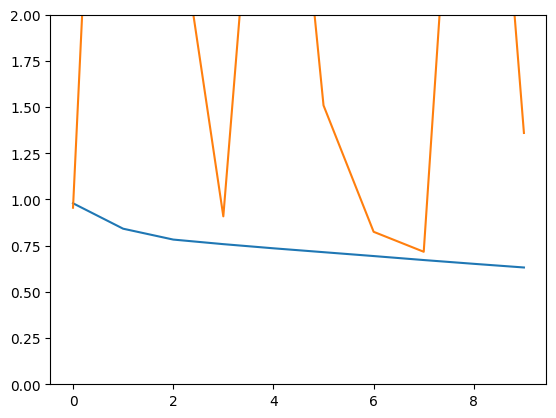

In [12]:
plt.plot(np.arange(0,10), resnet_loss_dict['train'])
plt.plot(np.arange(0,10), resnet_loss_dict['validate'])
plt.ylim(0,2);

In [13]:
correct = 0
total = 0
resnet_model_fabric.eval()
for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

74.39387512207031


In [14]:
resnet_model_fabric.eval()
y_true = []
y_pred = []

for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Calculate one-vs-all AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], y_pred == i)
    auc_scores.append(auc)

# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)

Macro F1 score: 0.4351157229171064
One-vs-all AUC: 0.6429232167400334


### Hyperparameter Tuning

In [61]:
batch_sizes = [8, 16]
learning_rates = [0.00001, 0.0001, 0.001]

resnet_dataset = {'train': FashionDataset(sample_train_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'validate': FashionDataset(sample_val_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'test': FashionDataset(sample_test_data, '/vast/amr10211/cv_data/masked_images', 'fabric')}

f1_dicts = []
loss_dicts = []
val_auc = []
train_auc = []
val_f1 = []
train_f1 = []

for batch_size in batch_sizes:
    sample_dataloader = {x: DataLoader(resnet_dataset[x], batch_size=batch_size,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}
    
    lr_f1_dict = []
    lr_loss_dict = []
    lr_val_auc = []
    lr_train_auc = []
    lr_val_f1 = []
    lr_train_f1 = []
    
    for learning_rate in learning_rates:

        print('-'*50)
        print(f'learning rate={learning_rate} and batch_size={batch_size}')
        print('-'*50)

        tune_model = ResNet18().to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(tune_model.parameters(), lr=learning_rate)

        tune_model_out, tune_f1_dict, tune_loss_dict = train_model(tune_model, 
                                                                    sample_dataloader, 
                                                                    optimizer, 
                                                                    loss_fn, 
                                                                    num_epochs=10, 
                                                                    verbose = True)
        
        lr_f1_dict.append(tune_f1_dict)
        lr_loss_dict.append(tune_loss_dict)
        
        # AUC for train dataset
        tune_model_out.eval()
        train_predictions = []
        train_targets = []
        for data in sample_dataloader['train']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)
            train_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            train_targets.extend(label.cpu().detach().numpy())

        train_auc_score = roc_auc_score(np.array(train_targets), np.array(train_predictions), average='macro', multi_class='ovr')
        train_f1_score = f1_score(np.array(train_targets), np.argmax(np.array(train_predictions), axis=1), average='macro')
        print(f'Train AUC for lr={learning_rate} and batch_size={batch_size}:\n{train_auc_score:.2f}')
        print(f'Train F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{train_f1_score:.2f}')
        lr_train_auc.append(train_auc_score)
        lr_train_f1.append(train_f1_score)
        

        # AUC for val dataset
        tune_model_out.eval()
        val_predictions = []
        val_targets = []
        for data in sample_dataloader['validate']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)

            val_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            val_targets.extend(label.cpu().detach().numpy())

        val_auc_score = roc_auc_score(np.array(val_targets), np.array(val_predictions), average='macro', multi_class='ovr')
        val_f1_score = f1_score(np.array(val_targets), np.argmax(np.array(val_predictions), axis=1), average='macro')
        print(f'Val AUC for lr={learning_rate} and batch_size={batch_size}:\n{val_auc_score:.2f}')
        print(f'Val F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{val_f1_score:.2f}')
        lr_val_auc.append(val_auc_score)
        lr_val_f1.append(val_f1_score)

    f1_dicts.append(lr_f1_dict)
    loss_dicts.append(lr_loss_dict)
    val_auc.append(lr_val_auc)
    train_auc.append(lr_train_auc)
    val_f1.append(lr_val_f1)
    train_f1.append(lr_train_f1)

with open('hyperparameter_sample_fabric.pkl', 'wb') as f:
    pickle.dump((f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1), f)

--------------------------------------------------
learning rate=1e-05 and batch_size=8
--------------------------------------------------
Epoch: 0/9
----------
Phase:train, epoch loss: 1.3882 Acc: 0.5806
Phase:validate, epoch loss: 1.2335 Acc: 0.6119
Epoch: 1/9
----------
Phase:train, epoch loss: 1.1471 Acc: 0.6310
Phase:validate, epoch loss: 1.1394 Acc: 0.6119
Epoch: 2/9
----------
Phase:train, epoch loss: 1.0979 Acc: 0.6310
Phase:validate, epoch loss: 1.1310 Acc: 0.5970
Epoch: 3/9
----------
Phase:train, epoch loss: 1.0716 Acc: 0.6331
Phase:validate, epoch loss: 1.1227 Acc: 0.5970
Epoch: 4/9
----------
Phase:train, epoch loss: 1.0259 Acc: 0.6351
Phase:validate, epoch loss: 1.1245 Acc: 0.5821
Epoch: 5/9
----------
Phase:train, epoch loss: 0.9990 Acc: 0.6492
Phase:validate, epoch loss: 1.1118 Acc: 0.6269
Epoch: 6/9
----------
Phase:train, epoch loss: 0.9522 Acc: 0.6855
Phase:validate, epoch loss: 1.0885 Acc: 0.5970
Epoch: 7/9
----------
Phase:train, epoch loss: 0.9242 Acc: 0.6956
Phas

In [62]:
with open('hyperparameter_sample_fabric.pkl', 'rb') as f:
    f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1 = pickle.load(f)

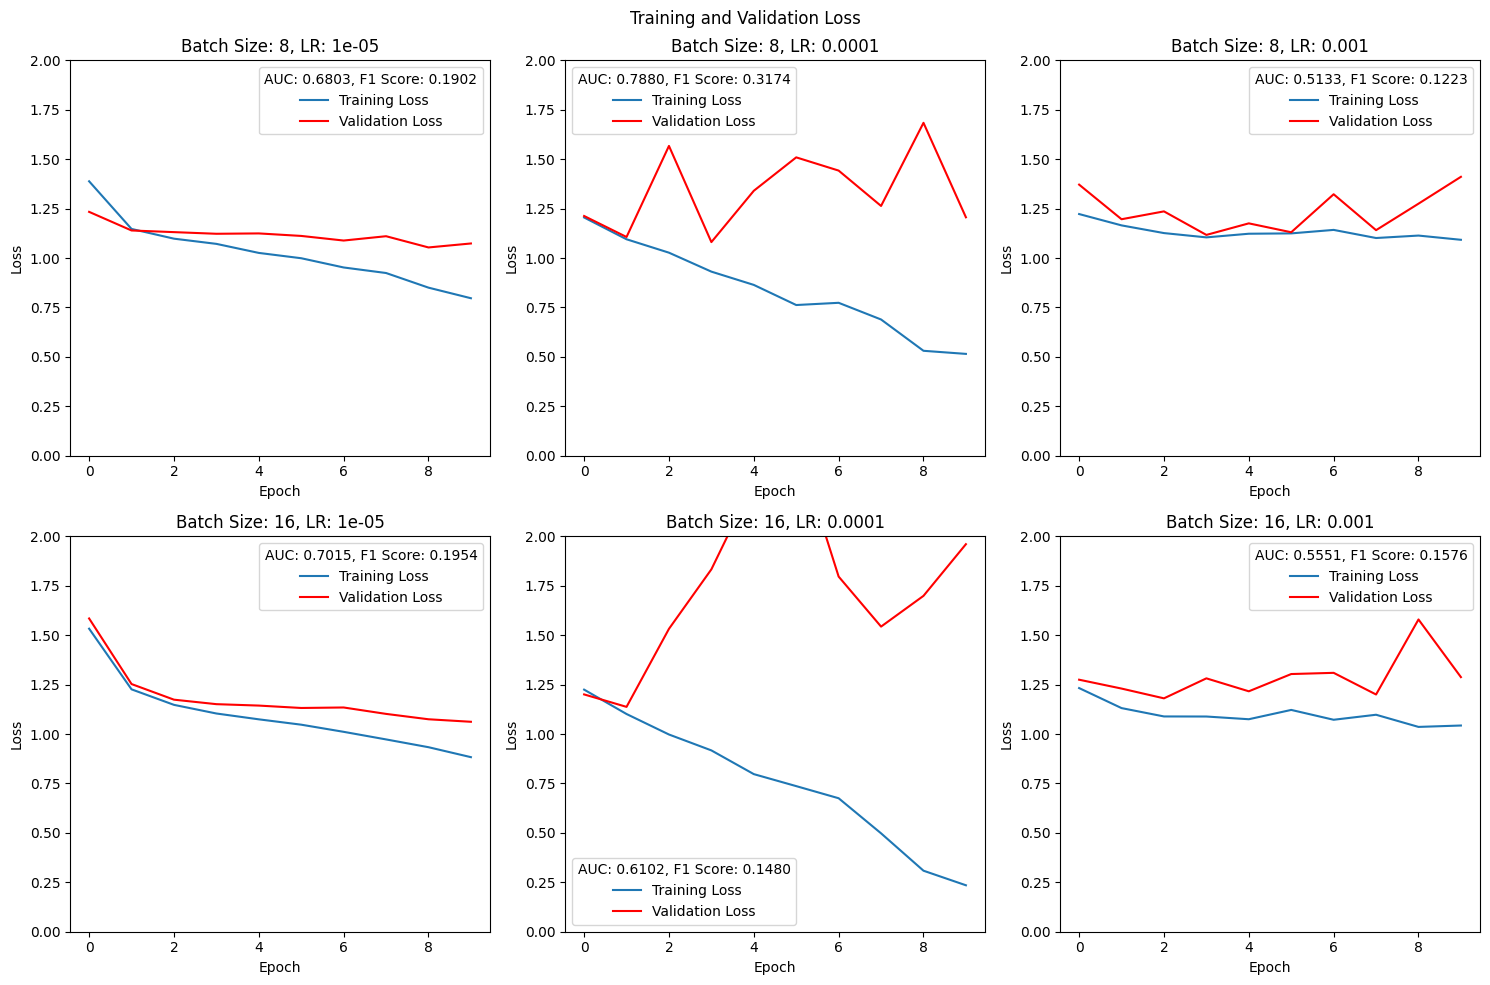

In [63]:
batch_sizes = [8, 16]
learning_rates = [0.00001, 0.0001, 0.001] 

fig, axs = plt.subplots(len(batch_sizes), len(learning_rates), figsize=(15, 10))
plt.suptitle('Training and Validation Loss')

for i, batch_size in enumerate(batch_sizes):
    for j, learning_rate in enumerate(learning_rates):
        axs[i,j].plot(loss_dicts[i][j]['train'], label='Training Loss')
        axs[i,j].plot(loss_dicts[i][j]['validate'], label='Validation Loss', color='red')
        axs[i,j].set_title(f'Batch Size: {batch_size}, LR: {learning_rate}')
        axs[i,j].set_xlabel('Epoch')
        axs[i,j].set_ylabel('Loss')
        axs[i,j].set_ylim(0,2)
        axs[i, j].legend(title=f'AUC: {val_auc[i][j]:.4f}, F1 Score: {val_f1[i][j]:.4f}')

plt.tight_layout()
plt.savefig('hyperparameter_tuning_loss_fabric.png')
plt.show()

### Hyperparameter Tuned Fabric Classification Model

In [ ]:
bs = 8
resnet_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'fabric')}

resnet_dataloader = {x: DataLoader(resnet_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [67]:
resnet_model_fabric = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model_fabric.parameters(), lr=0.0001)

resnet_model_fabric, resnet_f1_dict, resnet_loss_dict = train_model(resnet_model_fabric, 
                                                                     resnet_dataloader, 
                                                                     optimizer, 
                                                                     loss_fn=criterion, 
                                                                     num_epochs=10, 
                                                                     verbose=True)

Epoch: 0/9
----------
Phase:train, epoch loss: 0.8741 Acc: 0.6967
Phase:validate, epoch loss: 0.8629 Acc: 0.6778
Epoch: 1/9
----------
Phase:train, epoch loss: 0.7816 Acc: 0.7305
Phase:validate, epoch loss: 0.7833 Acc: 0.7235
Epoch: 2/9
----------
Phase:train, epoch loss: 0.7405 Acc: 0.7442
Phase:validate, epoch loss: 0.7466 Acc: 0.7340
Epoch: 3/9
----------
Phase:train, epoch loss: 0.7067 Acc: 0.7520
Phase:validate, epoch loss: 0.7780 Acc: 0.7134
Epoch: 4/9
----------
Phase:train, epoch loss: 0.6710 Acc: 0.7636
Phase:validate, epoch loss: 0.7443 Acc: 0.7381
Epoch: 5/9
----------
Phase:train, epoch loss: 0.6498 Acc: 0.7697
Phase:validate, epoch loss: 0.7595 Acc: 0.7209
Epoch: 6/9
----------
Phase:train, epoch loss: 0.6186 Acc: 0.7800
Phase:validate, epoch loss: 0.6974 Acc: 0.7501
Epoch: 7/9
----------
Phase:train, epoch loss: 0.5989 Acc: 0.7852
Phase:validate, epoch loss: 0.7544 Acc: 0.7250
Epoch: 8/9
----------
Phase:train, epoch loss: 0.5767 Acc: 0.7951
Phase:validate, epoch loss: 0.

In [68]:
torch.save(resnet_model_fabric, 'fabric_classification_model.pth')

In [69]:
with open('fabric_classification_model_loss_dict.pkl', 'wb') as f:
    pickle.dump(resnet_loss_dict, f)

(0.0, 2.0)

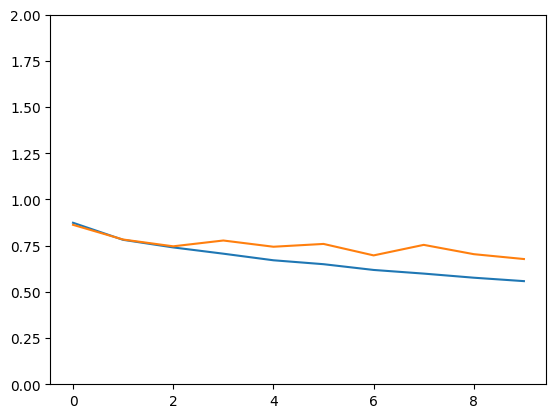

In [71]:
plt.plot(np.arange(0,10), resnet_loss_dict['train'])
plt.plot(np.arange(0,10), resnet_loss_dict['validate'])
plt.ylim(0,2);

In [72]:
correct = 0
total = 0
resnet_model_fabric.eval()
for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

In [74]:
resnet_model_fabric.eval()
y_true = []
y_pred = []

for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Calculate one-vs-all AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], y_pred == i)
    auc_scores.append(auc)

# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)


Macro F1 score: 0.5314069402364089
One-vs-all AUC: 0.7002833817517425


### 25 Epochs Tuned Fabric Classification Model

In [ ]:
bs = 8

resnet_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'fabric'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'fabric')}

resnet_dataloader = {x: DataLoader(resnet_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}

In [ ]:
resnet_model_fabric = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model_fabric.parameters(), lr=0.0001)

resnet_model_fabric, resnet_f1_dict, resnet_loss_dict = train_model(resnet_model_fabric, 
                                                                     resnet_dataloader, 
                                                                     optimizer, 
                                                                     loss_fn=criterion, 
                                                                     num_epochs=25, 
                                                                     verbose=True)

In [ ]:
torch.save(resnet_model_fabric, 'fabric_classification_model_25_epochs.pth')

In [ ]:
with open('fabric_classification_model_loss_dict_25_epochs.pkl', 'wb') as f:
    pickle.dump(resnet_loss_dict, f)

In [ ]:
plt.plot(np.arange(0,10), resnet_loss_dict['train'])
plt.plot(np.arange(0,10), resnet_loss_dict['validate'])
plt.ylim(0,2);

In [ ]:
correct = 0
total = 0
resnet_model_fabric.eval()
for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

In [ ]:
resnet_model_fabric.eval()
y_true = []
y_pred = []

for data in resnet_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = resnet_model_fabric(image)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Calculate one-vs-all AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], y_pred == i)
    auc_scores.append(auc)

# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)